<a href="https://colab.research.google.com/github/RomanenkovN/DeepLearningSchool/blob/master/HW_NST_pix2pix_CycleGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Neural Style Transfer



In [1]:
!pip install torch torchvision

**Importing Packages and Selecting a Device**

In [0]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as f
import torch.optim as optim

import torchvision.transforms as transforms
import torchvision.models as models

from PIL import Image
import copy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Загрузка изображений, будем изменять портрет Путина сверху стилем живописи Рембрантда, а снизу Пикассо

In [0]:
imsize = 512 if torch.cuda.is_available() else 128

loader = transforms.Compose([
                             transforms.Resize(imsize),
                             transforms.CenterCrop(imsize),
                             transforms.ToTensor()
])

def image_loader(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

style1_image = image_loader("rembrand.jpg")
style2_image = image_loader("picasso.jpg")
content_image = image_loader("putin.jpg")

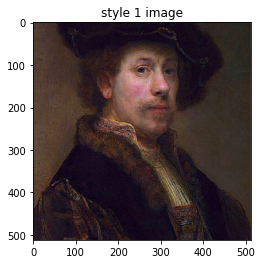

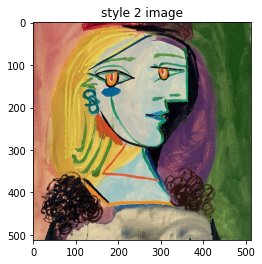

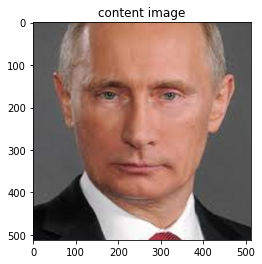

In [4]:
unloader = transforms.ToPILImage()

plt.ion()

def image_show(tensor, title=None):
    image= tensor.cpu().clone()
    image = image.squeeze(0)
    image = unloader(image)

    plt.imshow(image)

    if title is not None:
        plt.title(title)
    plt.pause(0.001)

plt.figure()
image_show(style1_image, title="style 1 image")
image_show(style2_image, title="style 2 image")

plt.figure()
image_show(content_image, title="content image")

### Loss functions

In [0]:
class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = f.mse_loss(input, self.target)
        return input      

In [0]:
def gram_matrix(input):
  a, b, c, d = input.size()
  features = input.view(a*b, c*d)

  G = torch.mm(features, features.t())
  return G.div(a*b*c*d)

In [0]:
class StyleLoss(nn.Module):
    def __init__(self, target1_features, target2_features):
        super(StyleLoss, self).__init__()
        self.target1 = gram_matrix(target1_features[:,:,:imsize//2]).detach()
        self.target2 = gram_matrix(target2_features[:,:,:imsize//2]).detach()

    def forward(self, input):
      G1 = gram_matrix(input[:,:,:(imsize//2)])
      G2 = gram_matrix(input[:,:,(imsize//2):])
      self.loss = (f.mse_loss(G1, self.target1) + f.mse_loss(G2, self.target2))/2
      return input

Импортируем VGG16


In [0]:
cnn = models.vgg16(pretrained=True).features.to(device).eval()

In [0]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, image):
        return (image - self.mean)/self.std

In [0]:
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_loss(cnn, cnn_normalizaton_mean, cnn_normalization_std,
                             content_image, style1_image, style2_image,
                             content_layers=content_layers_default,
                             style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    normalization = Normalization(cnn_normalization_mean, cnn_normalization_std).to(device)

    content_losses = []
    style_losses = []

    model = nn.Sequential(normalization)

    i = 0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i+=1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)        
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            target = model(content_image).detach()
            content_loss = ContentLoss(target)
            model.add_module('content_loss{}'.format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            target1 = model(style1_image).detach()
            target2 = model(style2_image).detach()
            style_loss = StyleLoss(target1, target2)
            model.add_module('style_loss{}'.format(i), style_loss)
            style_losses.append(style_loss)
          
    for i in range(len(model) -1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break
    
    model = model[:(i+1)]


    return model, content_losses, style_losses

In [0]:
def get_input_optimizer(input_img):
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

In [0]:
def run_style_transfer(model, content_losses, style_losses, input_img,
                       num_steps=300, style_weight=1000000, content_weight=1):
  
    optimizer = get_input_optimizer(input_img)

    run=[0]
    while run[0] <= num_steps:
        def closure():
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    input_img.data.clamp_(0, 1)

    return input_img

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


run [50]:
Style Loss :  nan Content Loss: 7.825294

run [100]:
Style Loss :  nan Content Loss: 8.478542

run [150]:
Style Loss :  nan Content Loss: 8.870728

run [200]:
Style Loss :  nan Content Loss: 8.913035

run [250]:
Style Loss :  nan Content Loss: 8.881800

run [300]:
Style Loss :  nan Content Loss: 8.627979



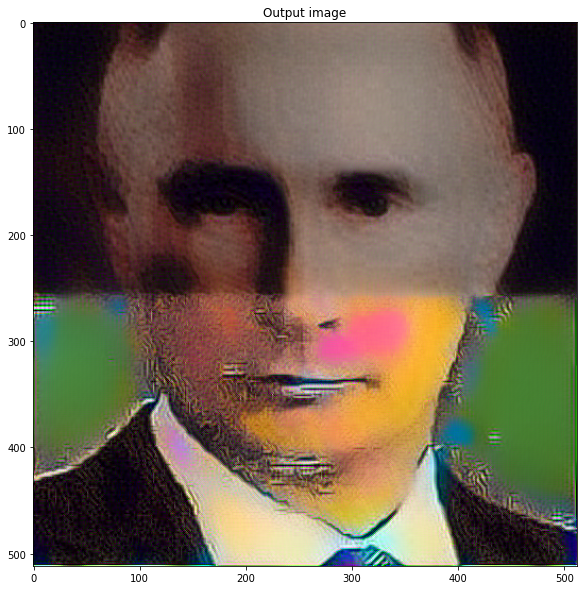

In [13]:
model, content_losses, style_losses = get_style_model_and_loss(cnn, cnn_normalization_mean, cnn_normalization_std,
                                                                   content_image, style1_image, style2_image)
input_img = content_image.detach()
output = run_style_transfer(model, content_losses, style_losses, input_img)
plt.figure(figsize=(10, 10))
image_show(output, title='Output image')

plt.ioff()
plt.show()